### Problem Setting

A bank wants to predict the creditworthiness of its customers. Based on the customer records, the credit history, etc., a customer should be classified as __creditworthy__ or __unworthy__ of credit. 
- __It is five times more ‘expensive’ for the bank to rate a customer who is unworthy of credit as creditworthy than vice versa.__ 

In addition, not all information is available for all customers. For __1,000 representatively selected customers__, the creditworthiness is known. For these customers the following data has been collected. (Features for which not all values are known are marked with the addition “incomplete”.)

### Task

You were asked to develop a predictive model that assesses the creditworthiness of future clients. It can be assumed that for these clients as well, there are missing values in the features “Purpose”, “Present employment since”, “Job” and “Foreign worker”.


- Read the data into Python and proprocess them. 
- Replace missing values ?using? linear regression or classification. 
- Identify a suitable method for solving the prediction problem, implement it in Python, and train the model. Evaluate the model in terms of the bank’s cost model. 
- Briefly motivate and document all the steps you have taken.

- Status of existing checking account
    - A11:...<0EUR
    - A12:0≤...<200EUR
    - A13: ... ≥ 200 EUR / salary assignments for at least 1 year 
    - A14: no checking account
- _Duration in month_ -- __Continuous__
- Credit history
    - A30: no credits taken/ all credits paid back duly 
    - A31: all credits at this bank paid back duly
    - A32: existing credits paid back duly till now
    - A33: delay in paying off in the past
    - A34: critical account/ other credits existing (not at this bank)
- __Purpose (incomplete)__
    - A40: car (new)
    - A41: car (used)
    - A42: furniture/equipment
    - A43: radio/television
    - A44: domestic appliances
    - A45: repairs
    - A46: education
    - A47: (vacation - does not exist?)
    - A48: retraining
    - A49: business
    - A410: others 
- _Credit amount_ __Continuous__
- Savings account/bonds
    - A61: ... < 100 EUR
    - A62:100≤...<500EUR
    - A63: 500 ≤ ... < 1000 EUR
    - A64: .. ≥ 1000 EUR
    - A65: unknown/ no savings account
- __Present employment since (incomplete)__
    - A71: unemployed
    - A72: ... < 1 year
    - A73:1≤...<4years 
    - A74:4≤...<7years 
    - A75: .. ≥ 7 years
- _Installment rate in percentage of disposable income_ -- __Continuous__
- Personal status and sex
    - A91: male: divorced/separated
    - A92: female: divorced/separated/married 
    - A93: male: single
    - A94: male: married/widowed
    - A95: female: single
- Other debtors / guarantors
    - A101: none
    - A102: co-applicant 
    - A103: guarantor
- _Present residence since_ -- __Continuous__ 
- Property
    - A121: real estate
    - A122: if not A121: building society savings agreement/ life insurance 
    - A123: if not A121/A122: car or other, not in attribute 6
    - A124: unknown / no property
- _Age in years_ -- __Continuous__
- Other installment plans
    - A141: bank 
    - A142: stores 
    - A143: none
- Housing
    - A151: rent
    - A152: own
    - A153: for free
- _Number of existing credits at this bank_ -- __Continuous__
- __Job (incomplete)__
    - A171: unemployed/ unskilled - non-resident 
    - A172: unskilled - resident
    - A173: skilled employee / official
    - A174: management/ self-employed/
    - A175: highly qualified employee/ officer
- _Number of people being liable to provide maintenance for_ -- __Continuous__
- Telephone
    - A191: none
    - A192: yes, registered under the customers name
- __Foreign worker (incomplete)__ 
    - A201: yes
    - A202: no 
- Creditworthy
    - 1: yes 
    - 2: no

In [115]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, fbeta_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import pprint
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. Data Exploration

## 1.1 Loading

In [116]:
raw_data = pd.read_csv('project04_kredit.dat', 
                        delimiter='\t', 
                        header=None)
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A14,36,A32,?,2299,A63,?,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,?,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,?,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,?,2,A191,?,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


In [117]:
cols = ['status_existing_account', 'duration_month', 'credit_history', 'purpose_IN',
       'credit_amount', 'savings_account', 'current_employment_IN', 'installment_rate_disposable_income',
       'personalstatus_sex', 'other_debtors', 'present_residence_since', 'property', 'age_years',
       'other_installment_plans', 'housing', 'numb_existing_credit', 'job_IN', 'number_people_being_liable',
       'telephone', 'foreign_worker_IN', 'creditworty']

semantic_raw_data = pd.read_csv('project04_kredit.dat', 
                     delimiter='\t', 
                     header=None, 
                     names = cols, 
                     na_values=['?'])

df_origin = semantic_raw_data.copy()

semantic_raw_data.head()

,status_existing_account,duration_month,credit_history,purpose_IN,credit_amount,savings_account,current_employment_IN,installment_rate_disposable_income,personalstatus_sex,other_debtors,...,property,age_years,other_installment_plans,housing,numb_existing_credit,job_IN,number_people_being_liable,telephone,foreign_worker_IN,creditworty
0,A14,36,A32,NaN,2299,A63,NaN,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,NaN,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,NaN,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,NaN,2,A191,NaN,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


## 1.2 Check Class Balance

In [118]:
prediction_feature = 'creditworty'

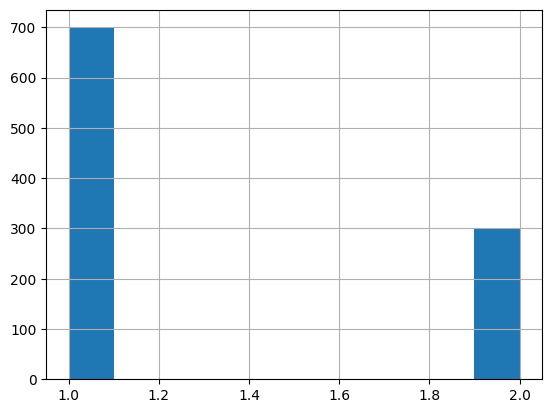

In [119]:
semantic_raw_data[prediction_feature].hist();

## 1.3 Check Null Data for Imputation

In [120]:
semantic_raw_data.isnull().sum() 

status_existing_account                 0
duration_month                          0
credit_history                          0
purpose_IN                            173
credit_amount                           0
savings_account                         0
current_employment_IN                 496
installment_rate_disposable_income      0
personalstatus_sex                      0
other_debtors                           0
present_residence_since                 0
property                                0
age_years                               0
other_installment_plans                 0
housing                                 0
numb_existing_credit                    0
job_IN                                232
number_people_being_liable              0
telephone                               0
foreign_worker_IN                     360
creditworty                             0
dtype: int64

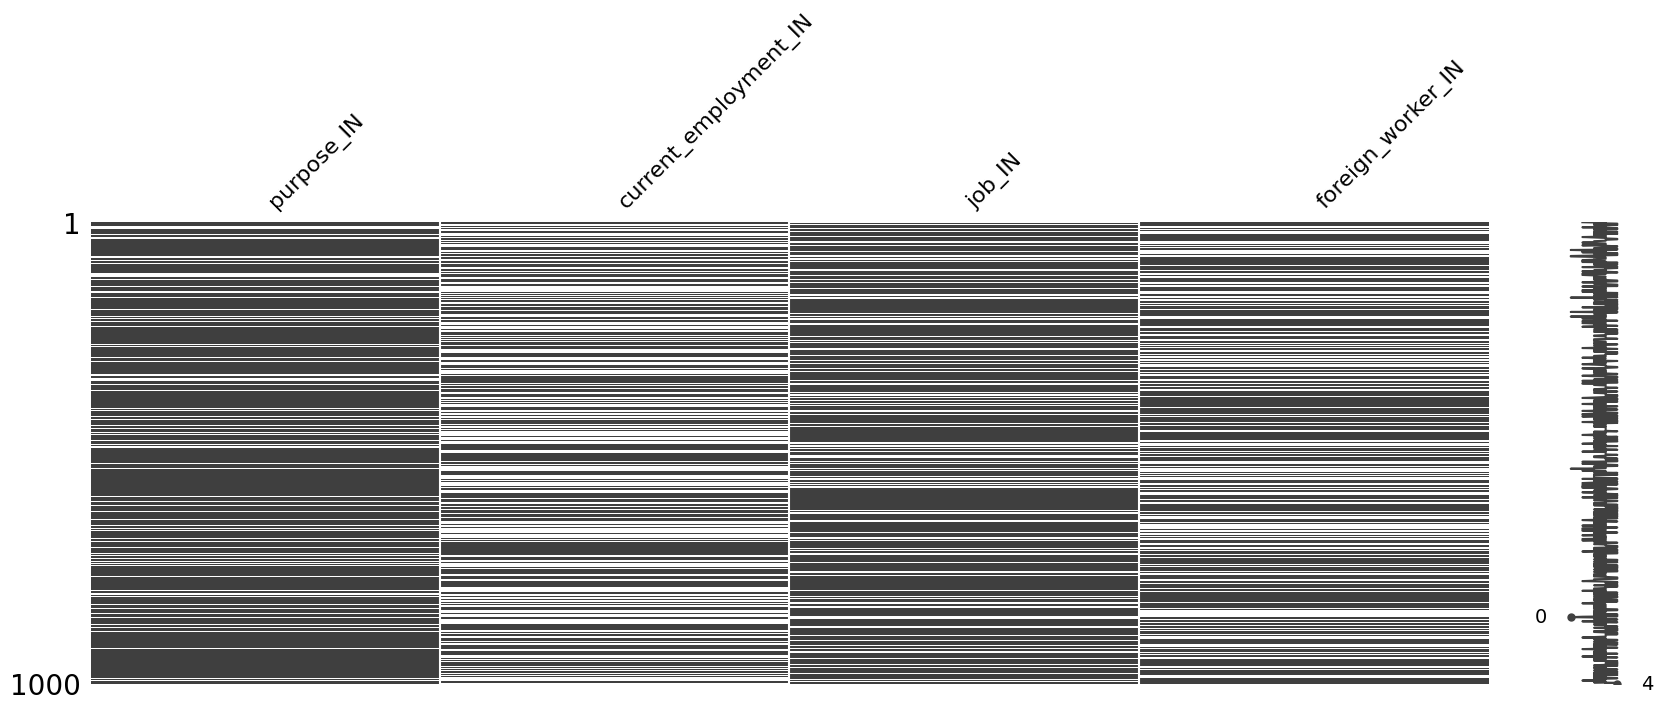

In [121]:
#https://github.com/ResidentMario/missingno

nan_category_ft = ['purpose_IN', 'current_employment_IN', 'job_IN', 'foreign_worker_IN']
msno.matrix(semantic_raw_data[nan_category_ft], figsize = (20, 6));

## 1.4 Check Continuous Features for Binning and/or Encoding

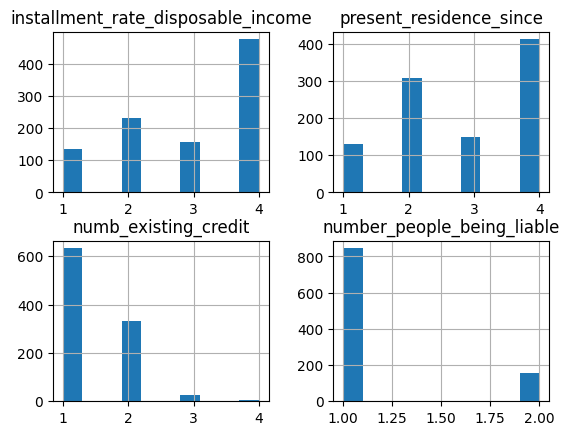

In [122]:
continuous_ft_pre_binned_cols = ['installment_rate_disposable_income', 
                                   'present_residence_since', 
                                   'numb_existing_credit',
                                   'number_people_being_liable']
semantic_raw_data[continuous_ft_pre_binned_cols].hist();

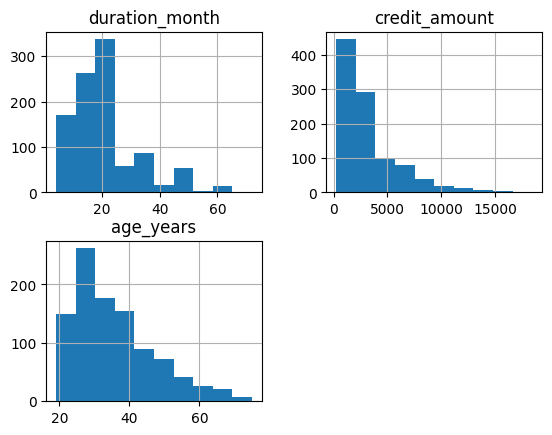

In [123]:
continuous_ft_to_bin_cols = ['duration_month', 
                               'credit_amount', 
                               'age_years']
semantic_raw_data[continuous_ft_to_bin_cols].hist();

#### Looking at the two histograms of the continuous features, binning is only needed for duration_month, credit_amount and age_years

## 1.4 Check Categorical Features for Encoding

In [124]:
categorical_ft_cols = ['status_existing_account', 
                        'credit_history', 
                        'savings_account', 
                        'current_employment_IN',
                        'property', 
                        'job_IN',
                        'personalstatus_sex', 
                        'purpose_IN', 
                        'other_debtors', 
                        'other_installment_plans',
                        'housing', 
                        'telephone', 
                        'foreign_worker_IN']

categorical_ordinal_ft_cols = ['status_existing_account', 
                                'credit_history', 
                                'savings_account', 
                                'current_employment_IN',
                                'job_IN']

In [125]:
semantic_raw_data[categorical_ft_cols].head()

,status_existing_account,credit_history,savings_account,current_employment_IN,property,job_IN,personalstatus_sex,purpose_IN,other_debtors,other_installment_plans,housing,telephone,foreign_worker_IN
0,A14,A32,A63,NaN,A123,A173,A93,NaN,A101,A143,A152,A191,NaN
1,A12,A32,A65,A73,A124,NaN,A93,A46,A101,A143,A153,A191,A201
2,A13,A32,A61,A74,A124,NaN,A93,A40,A101,A141,A153,A191,NaN
3,A14,A33,A61,A73,A121,A173,A94,A43,A101,A141,A152,A191,A201
4,A14,A32,A64,A74,A123,A173,A92,A40,A101,A143,A152,A192,A201


### These, including 4 incomplete features, are the categorical features that need to be encoded. 

# 2. Data Pre-Processing

In [126]:
semantic_raw_data = semantic_raw_data.replace({'creditworty': {2:0}})
semantic_raw_data.head()

,status_existing_account,duration_month,credit_history,purpose_IN,credit_amount,savings_account,current_employment_IN,installment_rate_disposable_income,personalstatus_sex,other_debtors,...,property,age_years,other_installment_plans,housing,numb_existing_credit,job_IN,number_people_being_liable,telephone,foreign_worker_IN,creditworty
0,A14,36,A32,NaN,2299,A63,NaN,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,NaN,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,NaN,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,NaN,2,A191,NaN,0
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


In [127]:
all_feautures = list(semantic_raw_data.columns)
print ("All Features:\n",all_feautures, "\n")

incomplete_feautures = nan_category_ft
print ("Incomplete Features:\n",incomplete_feautures, "\n")

complete_feautures = [feauture for feauture in all_feautures if feauture not in incomplete_feautures]
print ("Complete Features:\n",complete_feautures, "\n")

complete_feautures.remove(prediction_feature)
print ("Complete Features without target variable:\n",complete_feautures, "\n")

All Features:
 ['status_existing_account', 'duration_month', 'credit_history', 'purpose_IN', 'credit_amount', 'savings_account', 'current_employment_IN', 'installment_rate_disposable_income', 'personalstatus_sex', 'other_debtors', 'present_residence_since', 'property', 'age_years', 'other_installment_plans', 'housing', 'numb_existing_credit', 'job_IN', 'number_people_being_liable', 'telephone', 'foreign_worker_IN', 'creditworty'] 

Incomplete Features:
 ['purpose_IN', 'current_employment_IN', 'job_IN', 'foreign_worker_IN'] 

Complete Features:
 ['status_existing_account', 'duration_month', 'credit_history', 'credit_amount', 'savings_account', 'installment_rate_disposable_income', 'personalstatus_sex', 'other_debtors', 'present_residence_since', 'property', 'age_years', 'other_installment_plans', 'housing', 'numb_existing_credit', 'number_people_being_liable', 'telephone', 'creditworty'] 

Complete Features without target variable:
 ['status_existing_account', 'duration_month', 'credit_

## 2.1 Label Encoding and Data Imputation

In [128]:
def label_encode_for_regr_impute(df):
    """
    One-Hot encoding is applied on the data and then returned
    """

    df_with_nans = df.copy()

    # first select all categorical columns
    #convert all columns in df from datatype 'object' to 'category'
    #last part after apply - applies the conversion to each selected column
    df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
    
    #identify all categorical columns and store in variable
    categorical_columns = df.select_dtypes(include=['category']).columns

    # Convert categorical to numerical
    label_encoder = LabelEncoder()
    
    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column])
        
    #restore the NaN in their original place
    df_label_encoded_with_nan = df.where(~df_with_nans.isna(), df_with_nans)  
    
    return df_label_encoded_with_nan

### IterativeImputer with Logistic Regression to fill the imputed values as strings

In [129]:
def encoder_log_regr_imputer(raw_df, predictor_vars, missing_vars):

    # https://datasciencestunt.com/regression-imputation/
    
    #encode the df
    df_label_encoded_with_nan = label_encode_for_regr_impute(raw_df)
    #df_label_encoded_with_nan.head()
   
    #create a new df that contains the specified columns - prediction variables and the missing ones
    data = df_label_encoded_with_nan[predictor_vars + missing_vars]
    
    #set up the IterativeImputer set on LogisticRegression
    # missing values will be recognized as np.nan
    #the imputer will fill in the missing values with string values -- WHY?
    log_regr_imputer = IterativeImputer(estimator=LogisticRegression(),
                              missing_values = np.nan,
                              fill_value = 0)
    
    #fit the imputer to the data
    log_regr_imputer.fit(data)
    
    #apply the fitted imputer model on the data & store imputed values in variable. output is a np.array
    log_regr_imputed_array = log_regr_imputer.fit_transform(data)

    # create a copy of the original df
    log_regr_imputed_data = df_label_encoded_with_nan.copy()

    #rounding decimal values in categorical encoding values to the nearest whole number
    # and convert to integer
    log_regr_imputed_array_rounded = np.round(log_regr_imputed_array).astype(int)
    
    #update the missing values with the imputed data from the array 'log_regr_imputed_array'
    #substitute imputed values for missing values
    log_regr_imputed_data[missing_vars] = log_regr_imputed_array_rounded[:, -len(missing_vars):]

    return log_regr_imputed_data


In [130]:
imputed_data = encoder_log_regr_imputer (raw_df = semantic_raw_data, 
                                         predictor_vars = complete_feautures, 
                                         missing_vars = incomplete_feautures)

In [131]:
imputed_data.head()

,status_existing_account,duration_month,credit_history,purpose_IN,credit_amount,savings_account,current_employment_IN,installment_rate_disposable_income,personalstatus_sex,other_debtors,...,property,age_years,other_installment_plans,housing,numb_existing_credit,job_IN,number_people_being_liable,telephone,foreign_worker_IN,creditworty
0,3,36,2,4,2299,2,2,4,2,0,...,2,39,2,1,1,2,1,0,0,1
1,1,18,2,7,1239,4,2,4,2,0,...,3,61,2,2,1,2,1,0,0,1
2,2,24,2,0,947,0,3,4,2,0,...,3,38,0,2,1,2,2,0,0,0
3,3,15,3,4,1478,0,2,4,3,0,...,0,33,0,1,2,2,1,0,0,1
4,3,24,2,0,1525,3,3,4,1,0,...,2,34,2,1,1,2,2,1,0,1


In [132]:
df_origin[incomplete_feautures].describe()

,purpose_IN,current_employment_IN,job_IN,foreign_worker_IN
count,827,504,768,640
unique,10,5,4,2
top,A43,A73,A173,A201
freq,226,157,484,613


In [133]:
imputed_data[incomplete_feautures].describe()

,purpose_IN,current_employment_IN,job_IN,foreign_worker_IN
count,1000.00000,1000.00000,1000.000000,1000.000000
mean,2.97300,2.64800,1.939000,0.027000
std,2.67945,1.13991,0.579323,0.162164
min,0.00000,0.00000,0.000000,0.000000
25%,0.00000,2.00000,2.000000,0.000000
50%,3.00000,2.00000,2.000000,0.000000
75%,4.00000,4.00000,2.000000,0.000000
max,9.00000,4.00000,3.000000,1.000000


<Axes: >

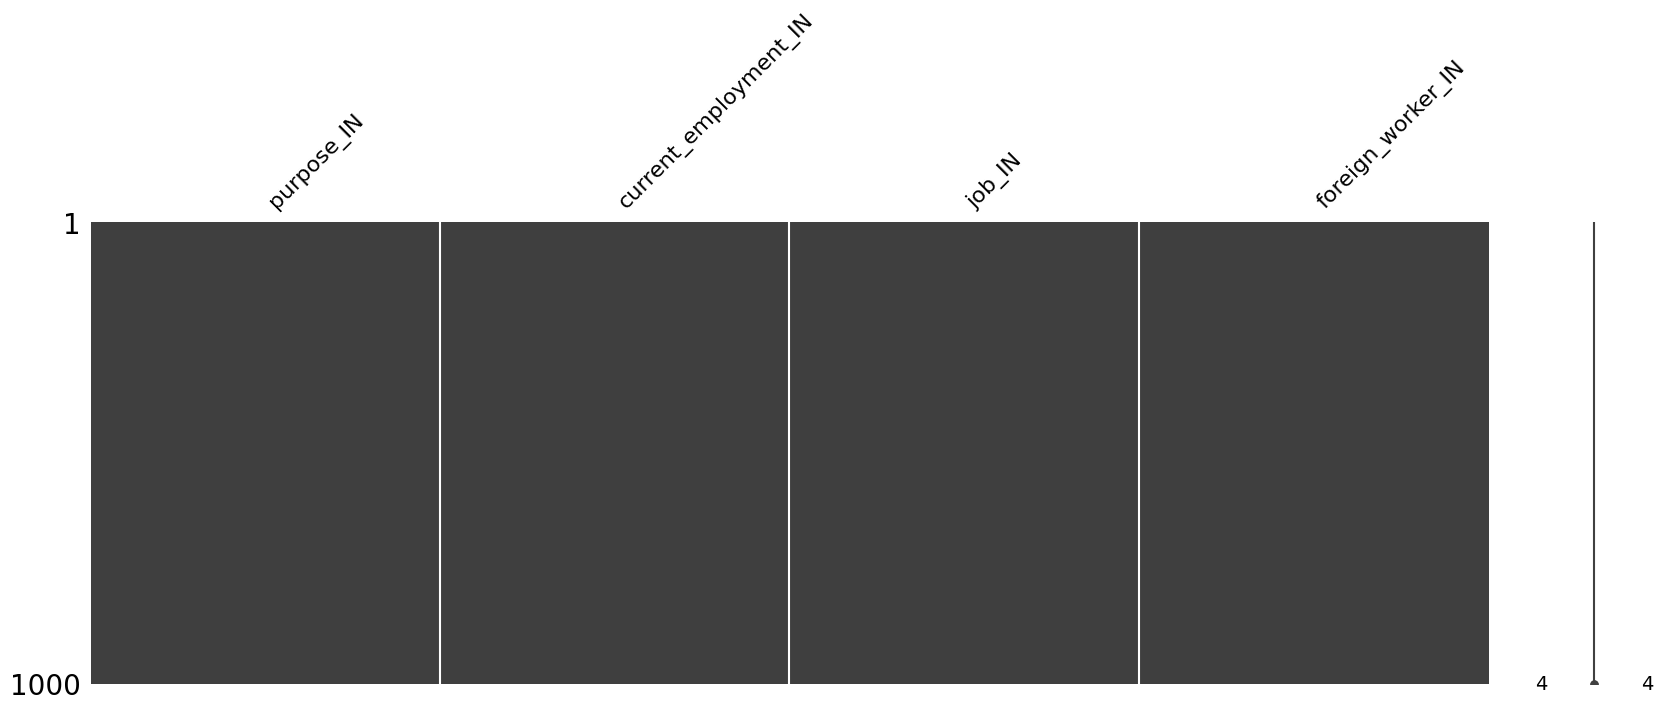

In [134]:
msno.matrix(imputed_data[nan_category_ft], figsize = (20, 6))

In [135]:
imputed_data.head()

,status_existing_account,duration_month,credit_history,purpose_IN,credit_amount,savings_account,current_employment_IN,installment_rate_disposable_income,personalstatus_sex,other_debtors,...,property,age_years,other_installment_plans,housing,numb_existing_credit,job_IN,number_people_being_liable,telephone,foreign_worker_IN,creditworty
0,3,36,2,4,2299,2,2,4,2,0,...,2,39,2,1,1,2,1,0,0,1
1,1,18,2,7,1239,4,2,4,2,0,...,3,61,2,2,1,2,1,0,0,1
2,2,24,2,0,947,0,3,4,2,0,...,3,38,0,2,1,2,2,0,0,0
3,3,15,3,4,1478,0,2,4,3,0,...,0,33,0,1,2,2,1,0,0,1
4,3,24,2,0,1525,3,3,4,1,0,...,2,34,2,1,1,2,2,1,0,1


## 1.4 Check Correlation of Features

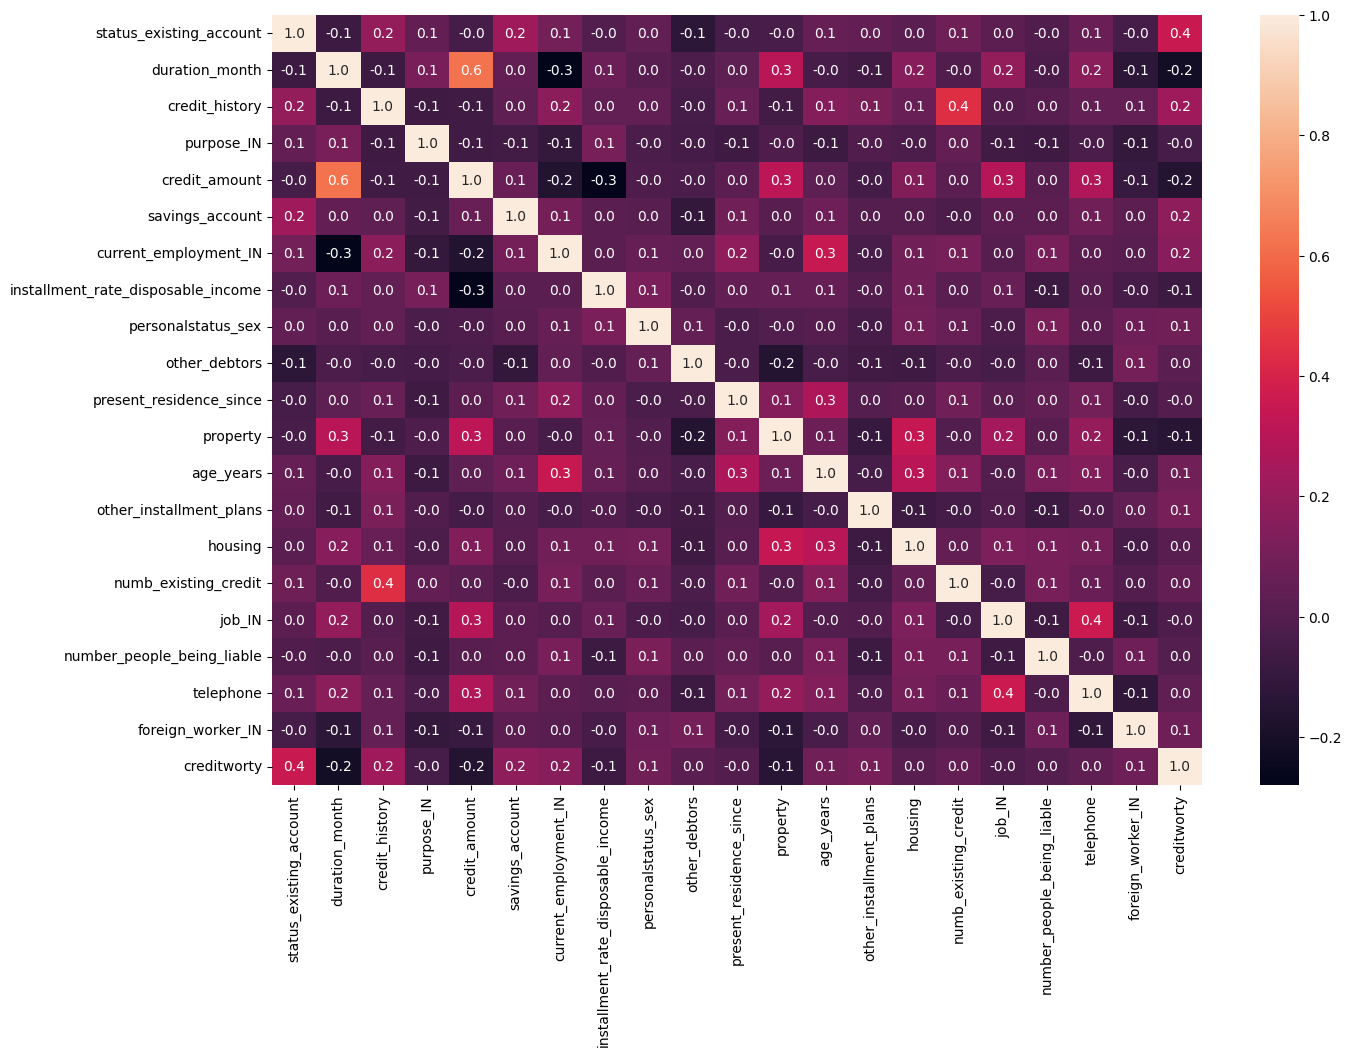

In [136]:
subjective_corr = imputed_data.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(subjective_corr, annot=True, ax=ax, fmt=".1f"
           );
#fig.savefig('heatmap.png', bbox_inches='tight');

## 2.2 Binning 

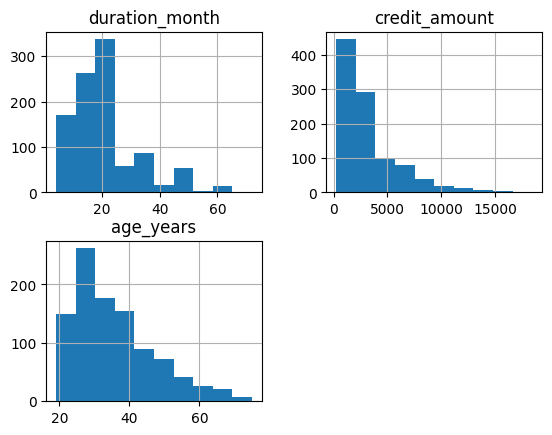

In [137]:
imputed_data[continuous_ft_to_bin_cols].hist();

In [138]:
continuous_ft_df = imputed_data[continuous_ft_to_bin_cols]

for feature in continuous_ft_to_bin_cols:
    kbin = KBinsDiscretizer(n_bins=4, encode='onehot', strategy='quantile', subsample=None)
    onehot_encoded = kbin.fit_transform(continuous_ft_df[[feature]])
    #convert onehot encoded array back to a single column of bins
    bin_indices = onehot_encoded.argmax(axis=1)
    #add bin_indices as a new col to DF & drop original column
    continuous_ft_df[feature] = bin_indices

binned_data = pd.concat([imputed_data.drop(columns=continuous_ft_to_bin_cols), 
                         continuous_ft_df], axis=1)

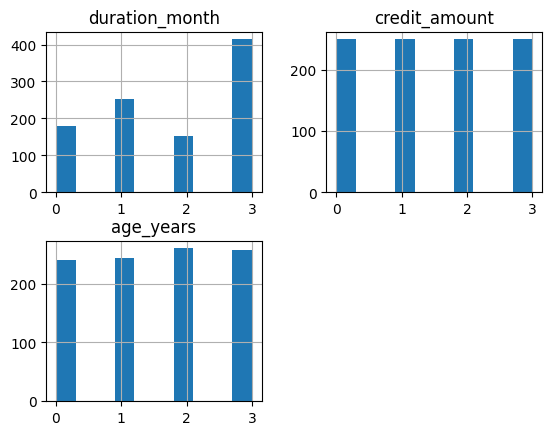

In [139]:
binned_data[continuous_ft_to_bin_cols].hist();

## 2.3 One Hot Encoding Categorical & Continuous Binned Features

In [140]:
binned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   status_existing_account             1000 non-null   int64
 1   credit_history                      1000 non-null   int64
 2   purpose_IN                          1000 non-null   int64
 3   savings_account                     1000 non-null   int64
 4   current_employment_IN               1000 non-null   int64
 5   installment_rate_disposable_income  1000 non-null   int64
 6   personalstatus_sex                  1000 non-null   int64
 7   other_debtors                       1000 non-null   int64
 8   present_residence_since             1000 non-null   int64
 9   property                            1000 non-null   int64
 10  other_installment_plans             1000 non-null   int64
 11  housing                             1000 non-null   int64
 12  numb_ex

In [141]:
def encode_onehot(input_df, cols_to_encode):
    
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    # Fit and transform the nominal data
    encoded_onehot = onehot_encoder.fit_transform(input_df[cols_to_encode])
    # Convert the result back to a DataFrame for better readability
    encoded_onehot_df = pd.DataFrame(encoded_onehot, 
                                     columns=onehot_encoder.get_feature_names_out(cols_to_encode))

    encoded_onehot_whole_df = pd.concat([input_df.drop(columns=cols_to_encode), 
                                         encoded_onehot_df], 
                                         axis=1)

    return encoded_onehot_whole_df

In [142]:
cols_to_encode = categorical_ft_cols + continuous_ft_pre_binned_cols + continuous_ft_to_bin_cols
cols_to_encode_without_ordinal = [ft for ft in cols_to_encode if ft not in categorical_ordinal_ft_cols]
print(cols_to_encode_without_ordinal)

encoded_data = encode_onehot(input_df = binned_data, 
                             cols_to_encode = cols_to_encode_without_ordinal)
encoded_data.info()

['property', 'personalstatus_sex', 'purpose_IN', 'other_debtors', 'other_installment_plans', 'housing', 'telephone', 'foreign_worker_IN', 'installment_rate_disposable_income', 'present_residence_since', 'numb_existing_credit', 'number_people_being_liable', 'duration_month', 'credit_amount', 'age_years']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   status_existing_account               1000 non-null   int64  
 1   credit_history                        1000 non-null   int64  
 2   savings_account                       1000 non-null   int64  
 3   current_employment_IN                 1000 non-null   int64  
 4   job_IN                                1000 non-null   int64  
 5   creditworty                           1000 non-null   int64  
 6   property_0                            1000 non-n

## 2.4 Balancing Class with Synthetic Minority Over-sampling Technique (SMOTE)

### Orginal Class Balance

In [143]:
positive_class = encoded_data['creditworty'].value_counts()[1]
negative_class = encoded_data['creditworty'].value_counts()[0]

print ("Creditworthy Class: ", positive_class)
print ("Not Creditworthy Class: ", negative_class)

Creditworthy Class:  700
Not Creditworthy Class:  300


In [144]:
#!pip3 install imblearn

In [145]:
#https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de
from imblearn.over_sampling import SMOTE

train_ft = encoded_data.drop('creditworty', axis=1)
pred_ft = encoded_data['creditworty']
smote = SMOTE(random_state=42)
train_ft_upsampled, pred_ft_upsampled = smote.fit_resample(train_ft, pred_ft)

In [146]:
preprocessed_data = train_ft_upsampled.copy()
preprocessed_data['creditworty'] = pred_ft_upsampled

### Final Class Balance

In [147]:
positive_class = preprocessed_data['creditworty'].value_counts()[1]
negative_class = preprocessed_data['creditworty'].value_counts()[0]

print ("Creditworthy Class: ", positive_class)
print ("Not Creditworthy Class: ", negative_class)

Creditworthy Class:  700
Not Creditworthy Class:  700


# 3. Training & Evaluation

## 3.1 Methods for Evaluation Metrics

In [148]:
def get_scores(y_pred, Y_test):
    """
    :param y_pred: Actual predictions from the model.
    :param Y_test: Labelled data for comparing predictions.
    :return: scores: Evaluation scores for the model based on prediction on test data.
    """
    accuracy = round(accuracy_score(Y_test, y_pred) * 100, 3)
    precision = round(precision_score(Y_test, y_pred) * 100, 3)
    recall = round(recall_score(Y_test, y_pred) * 100, 3)
    f1 = round(f1_score(Y_test, y_pred) * 100, 3)
    scores = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    return scores

## 3.2 Methods for Training Multiple Models

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

def train_eval_models(X_train, X_test, Y_train, Y_test):
    
    model_names = ['Logistic Regression', 
                   'Support Vector Machine',
                   'Random Forest', 
                   'Multi-layer perceptron']

    lr_model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
    lr_model.fit(X_train, Y_train)
    Y_pred = lr_model.predict(X_test)
    lr_score = get_scores(Y_pred, Y_test)
    
    svm_model = SVC(class_weight = 'balanced', gamma='auto')
    svm_model.fit(X_train, Y_train)
    Y_pred = svm_model.predict(X_test)
    svm_score = get_scores(Y_pred, Y_test)
    
    mlp_model = MLPClassifier(hidden_layer_sizes = 500, solver = 'sgd', activation='relu', batch_size = 50)
    mlp_model.fit(X_train, Y_train)
    Y_pred = mlp_model.predict(X_test)
    mlp_score = get_scores(Y_pred, Y_test)
    
    rf_model = RandomForestClassifier(n_estimators = 3000, n_jobs = -1)
    rf_model.fit(X_train, Y_train)
    Y_pred = rf_model.predict(X_test)
    rf_score = get_scores(Y_pred, Y_test)
    
    model_score_df = pd.DataFrame({'F1-score': [lr_score['f1'], 
                                                svm_score['f1'], 
                                                rf_score['f1'],
                                                mlp_score['f1']],
                                   
                                   'Precision': [lr_score['precision'], 
                                                 svm_score['precision'], 
                                                 rf_score['precision'], 
                                                 mlp_score['precision']],
                                   
                                   'Recall': [lr_score['recall'], 
                                              svm_score['recall'],
                                              rf_score['recall'], 
                                              mlp_score['recall']],
                                   
                                   'Accuracy': [lr_score['accuracy'], 
                                                svm_score['accuracy'], 
                                                rf_score['accuracy'], 
                                                mlp_score['accuracy']], 
                                },
                                index=model_names).sort_values(by=['F1-score'], ascending=False)
    
    trained_models = {"lr": lr_model,
                      "svm": svm_model,
                      "mlp": mlp_model,
                      "rf": rf_model
        }
    
    return model_score_df, trained_models

## 3.3 Splitting and Scaling Pre-processed Data

stratify parametr is used to create a __stratified split of the data__
- purpose: ensure that the proportion of samples for wach class is roughly the saem in both the training and test set is it is in the original dataset
- it is usefil when the target variable has an uneven distribution of classes
- and I want to maintain the same class distribution in both training and test set

__Benefits__:
- helps prevent sampling bias
- ensures that the model is trained and evaluated on representative samples of the data

In [150]:
def split_scale(pred_col, train_features):
    X_train, X_test, Y_train, Y_test = train_test_split(train_features, 
                                                        pred_col, 
                                                        test_size=0.25, 
                                                        stratify=pred_col)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, Y_train, Y_test

In [151]:
pred_col = preprocessed_data.creditworty
train_features = preprocessed_data.loc[:, preprocessed_data.columns != 'creditworty']

X_train, X_test, Y_train, Y_test = split_scale(pred_col, train_features)

## 3.4 Train and Evaluate All Models for Comparison

In [152]:
model_scores, trained_models = train_eval_models(X_train, X_test, Y_train, Y_test)
model_scores.head(10)

,F1-score,Precision,Recall,Accuracy
Random Forest,85.946,81.538,90.857,85.143
Support Vector Machine,80.447,78.689,82.286,80.000
Multi-layer perceptron,79.765,81.928,77.714,80.286
Logistic Regression,74.095,72.283,76.000,73.429


### Winner Model with F-1 Score: Random Forest

In [153]:
winner_model = trained_models['rf']

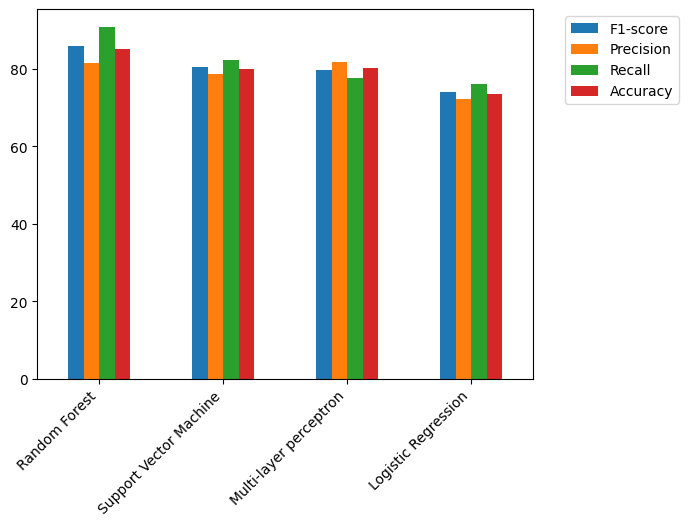

In [154]:
score_plot = model_scores.plot.bar(legend=True)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

## 3.5 Feature Importance with Random Forest

In [155]:
feature_imp = (winner_model.feature_importances_)
print(feature_imp)

[0.10996486 0.05078107 0.04750923 0.03248055 0.01939097 0.0170026
 0.0167806  0.01574909 0.01198857 0.00729434 0.01822406 0.01905732
 0.00915073 0.01688318 0.00802854 0.00132186 0.01499487 0.01740388
 0.00118941 0.00491798 0.00668848 0.00092063 0.01047996 0.00963531
 0.00569038 0.00703208 0.01265917 0.00601524 0.0151668  0.01261934
 0.02129356 0.00729517 0.01698503 0.0169157  0.00177051 0.00183702
 0.01190527 0.01667155 0.01205399 0.02755589 0.01693189 0.01710427
 0.0112413  0.01823352 0.01463426 0.01363206 0.00243573 0.00068391
 0.00909702 0.00898383 0.02714151 0.01406695 0.01472165 0.02773418
 0.01363622 0.01849184 0.02112967 0.01964191 0.01857222 0.01788853
 0.01804296 0.01464981]


In [156]:
feature_imp_dict = {
  "status_existing_account": 0,
  "credit_history": 0,
  "savings_account": 0,
  "current_employment": 0,
  "property": 0,
  "job": 0,
  "personalstatus": 0,
  "purpose": 0,
  "other_debtors": 0,
  "other_installment_plans": 0,
  "telephone": 0,
  "foreign_worker": 0,
  "installment_rate_disposable_income": 0,
  "present_residence_since": 0,
  "numb_existing_credit": 0,
  "number_people_being_liable": 0,
  "duration_month": 0,
  "credit_amount": 0,
  "age_years": 0
}

feature_imp_dict['status_existing_account'] = sum(feature_imp[0:0 + 1])
feature_imp_dict['credit_history'] = sum(feature_imp[1:1 + 1])
feature_imp_dict['savings_account'] = sum(feature_imp[2:2 + 1])
feature_imp_dict['current_employment'] = sum(feature_imp[3:3 + 1])
feature_imp_dict['property'] = sum(feature_imp[5:8 + 1])
feature_imp_dict['job'] = sum(feature_imp[4:4 + 1])
feature_imp_dict['personalstatus'] = sum(feature_imp[9:12 + 1])
feature_imp_dict['purpose'] = sum(feature_imp[13:22 + 1])
feature_imp_dict['other_debtors'] = sum(feature_imp[23:25 + 1])
feature_imp_dict['other_installment_plans'] = sum(feature_imp[26:28 + 1])
feature_imp_dict['housing'] = sum(feature_imp[29:31 + 1])
feature_imp_dict['telephone'] = sum(feature_imp[32:33 + 1])
feature_imp_dict['foreign_worker'] = sum(feature_imp[34:35 + 1])
feature_imp_dict['installment_rate_disposable_income'] = sum(feature_imp[36:39 + 1])
feature_imp_dict['present_residence_since'] = sum(feature_imp[40:43 + 1])
feature_imp_dict['numb_existing_credit'] = sum(feature_imp[44:47 + 1])
feature_imp_dict['number_people_being_liable'] = sum(feature_imp[48:49 + 1])
feature_imp_dict['duration_month'] = sum(feature_imp[50:53 + 1])
feature_imp_dict['credit_amount'] = sum(feature_imp[54:57 + 1])
feature_imp_dict['age_years'] = sum(feature_imp[59:61 + 1])

In [157]:
feature_importance = sorted(feature_imp_dict.items())
feature_importance.sort(key = lambda x: x[1], reverse = True)  
x, y = zip(* feature_importance)

feature_importance_df = pd.DataFrame({'features': x, 'importance': y}) 
for i, row in feature_importance_df.iterrows():
    rounded_value = round(feature_importance_df.at[i,'importance']*100,3)
    feature_importance_df.at[i,'importance'] = rounded_value

feature_importance_df.head(20)

,features,importance
0,status_existing_account,10.996
1,duration_month,8.366
2,purpose,8.283
3,credit_amount,7.290
4,installment_rate_disposable_income,6.819
5,present_residence_since,6.351
6,property,6.152
7,personalstatus,5.373
8,credit_history,5.078
9,age_years,5.058


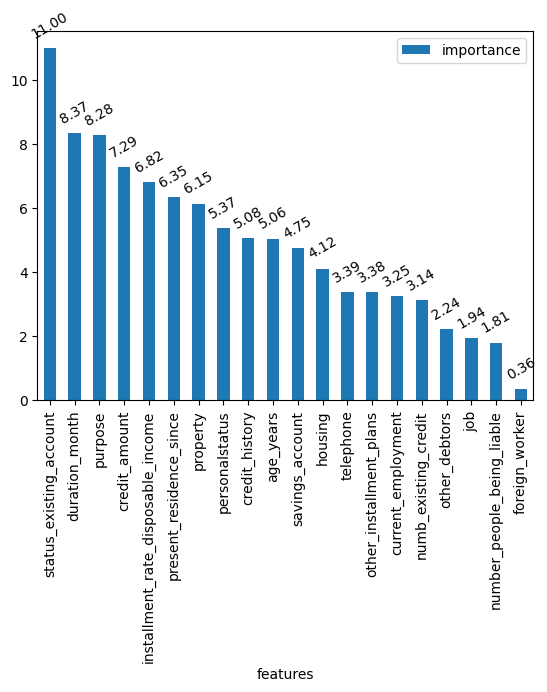

In [158]:
ax = feature_importance_df.plot.bar(x="features", y="importance", legend=True)

# Add labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', rotation=30, 
                xytext=(0, 5), textcoords='offset points') 

plt.show();
#plt.savefig('feature_importance_plot.png', bbox_inches='tight', dpi=300)

## 3.6 Compare Re-Training with Reduced Features

In [159]:
def reduce_train_features(FEATURE_CUTOFF_THRESHOLD):
    features_to_cutoff =[]

    for i, row in feature_importance_df.iterrows():
        if row['importance'] <= FEATURE_CUTOFF_THRESHOLD:
            features_to_cutoff.append(row['features'])

    print ("Dropping the following features based on Threshold: ", features_to_cutoff)
    print ("Number of Dropped Features:", len(features_to_cutoff))
    reduced_train_features = train_features
    for feature_to_cutoff in features_to_cutoff:
        reduced_train_features = reduced_train_features.loc[:,~reduced_train_features.columns.str.startswith(feature_to_cutoff)]

    return reduced_train_features

### 3.6.1 Without Reducing any Features

In [160]:
reduced_train_features = reduce_train_features(FEATURE_CUTOFF_THRESHOLD = 0)
X_train, X_test, Y_train, Y_test = split_scale(pred_col, reduced_train_features)
model_scores_0, trained_models_0 = train_eval_models(X_train, X_test, Y_train, Y_test)
model_scores_0.head(10)

Dropping the following features based on Threshold:  []
Number of Dropped Features: 0


,F1-score,Precision,Recall,Accuracy
Random Forest,87.363,84.127,90.857,86.857
Support Vector Machine,85.797,87.059,84.571,86.000
Multi-layer perceptron,83.432,86.503,80.571,84.000
Logistic Regression,77.457,78.363,76.571,77.714


### 3.6.2 With Reducing Features lower than 5% importance

In [161]:
reduced_train_features = reduce_train_features(FEATURE_CUTOFF_THRESHOLD = 5)
X_train, X_test, Y_train, Y_test = split_scale(pred_col, reduced_train_features)
model_scores_5, trained_models_5 = train_eval_models(X_train, X_test, Y_train, Y_test)
model_scores_5.head(10)

Dropping the following features based on Threshold:  ['savings_account', 'housing', 'telephone', 'other_installment_plans', 'current_employment', 'numb_existing_credit', 'other_debtors', 'job', 'number_people_being_liable', 'foreign_worker']
Number of Dropped Features: 10


,F1-score,Precision,Recall,Accuracy
Random Forest,87.399,82.323,93.143,86.571
Support Vector Machine,82.955,82.486,83.429,82.857
Multi-layer perceptron,81.657,84.663,78.857,82.286
Logistic Regression,78.161,78.613,77.714,78.286


### 3.6.3 With Reducing Features lower than 7% importance

In [162]:
reduced_train_features = reduce_train_features(FEATURE_CUTOFF_THRESHOLD = 7)
X_train, X_test, Y_train, Y_test = split_scale(pred_col, reduced_train_features)
model_scores_7, trained_models_7 = train_eval_models(X_train, X_test, Y_train, Y_test)
model_scores_7.head(10)

Dropping the following features based on Threshold:  ['installment_rate_disposable_income', 'present_residence_since', 'property', 'personalstatus', 'credit_history', 'age_years', 'savings_account', 'housing', 'telephone', 'other_installment_plans', 'current_employment', 'numb_existing_credit', 'other_debtors', 'job', 'number_people_being_liable', 'foreign_worker']
Number of Dropped Features: 16


,F1-score,Precision,Recall,Accuracy
Random Forest,73.504,73.295,73.714,73.429
Support Vector Machine,70.552,76.159,65.714,72.571
Logistic Regression,70.030,72.840,67.429,71.143
Multi-layer perceptron,68.308,74.000,63.429,70.571


## 3.7 Train & Evalaute Random Forest (without dropping features)

In [163]:
reduced_train_features = reduce_train_features(FEATURE_CUTOFF_THRESHOLD = 0)
X_train, X_test, Y_train, Y_test = split_scale(pred_col, reduced_train_features)

Dropping the following features based on Threshold:  []
Number of Dropped Features: 0


## 3.7.1 Randomized Grid Search with 10-Fold Cross-Validation

In [164]:
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf_model_random_ini = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                                         param_distributions = random_grid, 
                                         n_iter = 100, 
                                         cv = 10, 
                                         verbose=1,
                                         random_state=42, 
                                         n_jobs = -1,
                                         scoring='f1')
rf_model_random_ini.fit(X_train, Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100,
                                                      110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 10, 20, 30],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=1)

In [165]:
print('Best hyperparameters are: '+ str(rf_model_random_ini.best_params_))
print('Best score is: '+ str(rf_model_random_ini.best_score_))

Best hyperparameters are: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}
Best score is: 0.8558203028136223


## 3.8 Winner Model Scoring

### 3.8.1 F-1 Score, F-0.5 Score, Precision, Recall, Accuracy

In [166]:
Y_pred = rf_model_random_ini.predict(X_test)
winner_scores = get_scores(Y_pred, Y_test)

f_05 = round(fbeta_score(Y_test, Y_pred, beta=0.5) * 100, 3)
winner_scores['f_05'] = f_05

winner_scores

{'accuracy': 87.143,
 'precision': 82.828,
 'recall': 93.714,
 'f1': 87.936,
 'f_05': 84.798}

In [167]:
print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       152
           1       0.94      0.83      0.88       198

    accuracy                           0.87       350
   macro avg       0.87      0.88      0.87       350
weighted avg       0.88      0.87      0.87       350



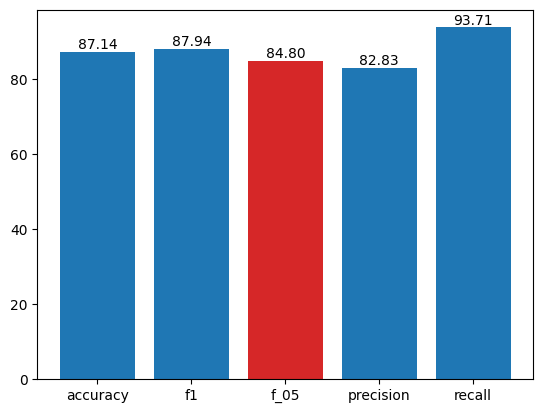

In [168]:
winner_scores_lists = sorted(winner_scores.items()) 
label, score = zip(*winner_scores_lists)

bars = plt.bar(label, score, color=['tab:blue', 'tab:blue', 'tab:red', 'tab:blue', 'tab:blue'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

### 3.8.2 Confusion Matrix

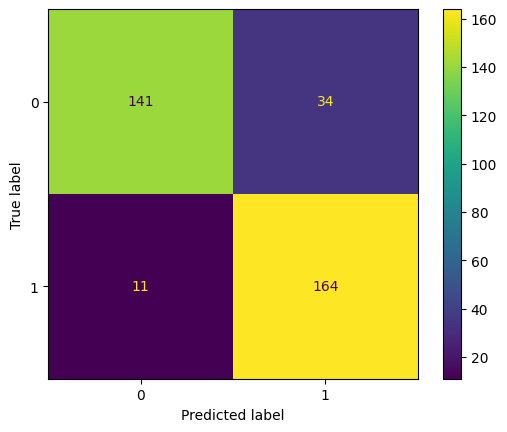

In [169]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.show()

### 3.8.3 Area under the ROC curve

In [170]:
Y_pred_proba = rf_model_random_ini.predict_proba(X_test)[:, 1]
auroc = round(roc_auc_score(Y_test, Y_pred_proba) * 100, 3)
auroc

94.047

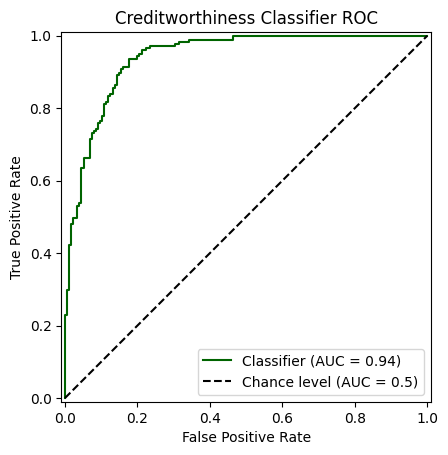

In [171]:
display = RocCurveDisplay.from_predictions(Y_test, 
                                            Y_pred_proba,
                                            color="darkgreen",
                                            plot_chance_level=True,)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Creditworthiness Classifier ROC",
)